In [12]:
import numpy as np
from smrt import make_snowpack, make_model, sensor_list, make_ice_column, PSU, sensor
from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09
import matplotlib.pyplot as plt
from smrt.permittivity.saline_ice import saline_ice_permittivity_pvs_mixing
from smrt.permittivity.brine import brine_volume
import smrt
from collections import defaultdict
from string import ascii_lowercase
from smrt.interface.iem_fung92_brogioni10 import IEM_Fung92_Briogoni10
import warnings
import itertools
import sys
sys.path.append('/home/robbie/Dropbox/inverter')
import inverter_tools
import sensitivity_tools
import pandas as pd

deg = r'$^{\circ}$ '

zero_K = 273.15

f19 = 19e9
f37 = 37e9
f89 = 89e9

deg_C = r'$^{\circ}$C'

In [13]:
def run_model(snow_depth,
              ice_thickness,
              ice_salinity,
              ice_density,
              temp,
              snow_CL_e3,
              ice_CL_e3,
              snow_density,
              snow_sal,
              snow_roughness_rms,
              snow_roughness_CL,
              ice_roughness_rms,
              ice_roughness_CL,
              angles,
              ice_type='multiyear',
              AMSR2=False,
              ):
    
    """Runs SMRT from geophysical variables and returns a dictionary of results"""
    
    snow_air_interface = IEM_Fung92_Briogoni10(roughness_rms=snow_roughness_rms * 1e-3,
                                               corr_length=snow_roughness_CL * 1e-3)

    snow_ice_interface = IEM_Fung92_Briogoni10(roughness_rms=ice_roughness_rms * 1e-3,
                                               corr_length=ice_roughness_CL * 1e-3)

    ice_column = make_ice_column(ice_type=ice_type,
                                 thickness=[ice_thickness],
                                 temperature=temp,
                                 brine_inclusion_shape='random_needles',
                                 corr_length=ice_CL_e3 / 1000,
                                 density=ice_density,
                                 salinity=ice_salinity * PSU,
                                 microstructure_model='exponential',
                                 add_water_substrate='ocean',
                                 ice_permittivity_model=saline_ice_permittivity_pvs_mixing,
                                 interface=snow_ice_interface,

                                 )

    snowpack = make_snowpack(thickness=[snow_depth],
                             microstructure_model="exponential",
                             density=snow_density,
                             temperature=temp,
                             corr_length=snow_CL_e3 / 1000,
                             salinity=snow_sal,
#                              ice_permittivity_model = saline_snow_permittivity_geldsetzer09,
                             interface=snow_air_interface,
                             )

    medium = snowpack + ice_column

    sensor = smrt.sensor.passive([f19,f37,f89], angles, polarization=['V', 'H'])

    m = make_model("iba", "dort")

    res = m.run(sensor, medium)
    
    res = pd.DataFrame(res.return_as_dataframe(name='Tb').to_records())

    results = {}

    for freq, pol in itertools.product([f19,f37,f89], ['V', 'H']):

        freq_name = str(freq)[:2]

        results[f'{freq_name} {pol}'] = np.array(res[(res['frequency']==freq) & (res['polarization']==pol)]['Tb'])

    return results

def plot_angular_result(res, marker='x', ax=0, show=False):
    angles = np.arange(0, 51, 5)

    if ax == 0:
        fig, ax = plt.subplots(1, 1)

    for key in res.keys():

            
            
        if marker == 'x': value_label='low'
        elif marker == 'o': value_label='high'    
        
        ax.set_ylabel('Tb (K)', fontsize='x-large')
        ax.set_xlabel('Angle', fontsize='x-large')
        ax.plot(angles, res[key], marker=marker,
                label=f'{key}_{value_label}', color=color, ls=ls)

    if show:
        plt.show()

    return (ax)


In [18]:
canonical = {'snow_depth': 0.23,
             'ice_thickness': 0.89,
             'ice_salinity': 0.89,
             'ice_density': 805.45,
             'temp': 260.87, 
             'snow_CL_e3': 0.4,
             'ice_CL_e3': 0.28,
             'snow_density': 378.83,
             'snow_roughness_rms': 1.5,
             'snow_roughness_CL': 24.37,
             'ice_roughness_rms': 1.81,
             'ice_roughness_CL': 100.97}


initial_bounds = [(0.08,0.4), # Snow Depth
                 (0.6,1.5), # Ice Thickness
                 (0.1,3), # Ice Salinity
                 (790,920), # Ice Density
                 (255,270), # Temperature
                 (0.1,0.4), # Snow MCL
                 (0.1,1), # Ice MCL
                 (250,400), # Snow Density
                 (0.3,1.5), # Snow RMS
                 (8,120), # Snow RCL
                 (0.1,2.3), # Ice RMS
                 (10,150)] # Ice RCL


variable_titles = {'snow_depth': 'Snow Depth (m)',
                     'ice_thickness': 'Ice Thickness (m)',
                     'ice_salinity': 'Ice Salinity (PSU)',
                     'ice_density': r'Ice Density kgm$^{-3}$',
                     'temp': 'Temperature (K)', 
                     'snow_CL_e3': 'Snow Grain CL (mm)',
                     'ice_CL_e3': 'Ice Grain CL (mm)',
                     'snow_density': r'Snow Density kgm$^{-3}$',
                     'snow_roughness_rms': 'Snow/Air RMS Height (mm)',
                     'snow_roughness_CL': 'Snow/Air Surf CL (mm)',
                     'ice_roughness_rms': 'Snow/Ice RMS Height (mm)',
                     'ice_roughness_CL': 'Snow/Ice Surf CL (mm)'}

pretty_bounds = inverter_tools.print_params(initial_bounds)

def run_sensitivity_from_params(params,
                                angles= np.arange(0, 51, 5),
                                ice_type='multiyear',
                                AMSR2=False,
                               ):
    
    trial_res = run_model(snow_depth=params[0],
                          ice_thickness=params[1],
                          ice_salinity=params[2],
                          ice_density=params[3],
                          temp=params[4],
                          snow_CL_e3=params[5],
                          ice_CL_e3=params[6],
                          snow_density=params[7],
                          snow_sal=0,
                          snow_roughness_rms=params[8],
                          snow_roughness_CL=params[9],
                          ice_roughness_rms=params[10],
                          ice_roughness_CL=params[11],
                          angles=angles,
                          ice_type=ice_type,
                          AMSR2=AMSR2,
                          )


    return (trial_res)

def angular_sensitivity(canonical,
                variable,
                bounds,
                ax=0,
                show=True,
                penetration=False):
    trial_dict = canonical.copy()

    for value, marker in zip([bounds[variable][0], bounds[variable][1]], ['x', 'o']):
        
        trial_dict[variable] = value

        trial_params = [value for value in list(trial_dict.values())]

        run = run_sensitivity_from_params(trial_params)

        ax = plot_angular_result(run, marker=marker, ax=ax)

    if show: plt.show()

    return (ax)

def clean_dataframe(df):
    
    for frequency in [f19,f37,f89]:
        df.loc[(df[frequency]>300),frequency]=np.nan
        df.loc[(df[frequency]<50),frequency]=np.nan
        
    return(df)
    
                                
def param_sensitivity(canonical,
                        param,
                        bounds,
                        ax=0,
                        show=True,
                        GR=False,
                        angles=np.array([0]),
                        ls='-',
                        legend_str = '',
                        ice_type='multiyear',
                        datapoints=50,
                        AMSR2=False):
                                
    trial_dict = canonical.copy()

    param_result = []

    for param_value in np.linspace(bounds[param][0], bounds[param][1], datapoints):

        trial_dict[param] = param_value

        trial_params = [value for value in list(trial_dict.values())]

        run = run_sensitivity_from_params(trial_params, angles=angles, ice_type=ice_type,AMSR2=AMSR2)
        
        param_result.append(  {'param_value' : param_value, 
                               f19 : run[str(f19)[:2]+' V'][0],
                               f37 : run[str(f37)[:2]+' V'][0],
                               f89 : run[str(f89)[:2]+' V'][0],
                              }
                           )
        
    df = pd.DataFrame(param_result)
    
    df = clean_dataframe(df)

    ax = plot_param_result(df,
                           param_name=param,
                           ax=ax, 
                           GR=GR,
                           ls=ls,
                           legend_str=legend_str,
                           AMSR2=AMSR2,
                           angle=angles[0])

    if show: plt.show()

    return (ax)


def plot_param_result(df, param_name, ax=0, show=False, GR=False, ls='-', legend_str=None, AMSR2=False, angle=0):

    if ax == 0:
        fig, ax = plt.subplots(1, 1)
    
    color = 'darkblue' if AMSR2 else 'crimson'
#     ls = '--' if angle == 55 else '-'
    mission = '37/19' if AMSR2 else '36/23'
    if GR:
        
        df['GR'] = (df['36.5 V'] - df['23.8 V'])/(df['36.5 V'] + df['23.8 V'])
        
        ax.plot(df['param_value'], df['GR'],
                    label=f'{angle}{deg} {mission}', color=color, ls=ls)

        
    else:
        for col_name in df.columns[1:]:

            if '23' in col_name:
                color = 'darkblue'
            else:
                color = 'crimson'

            
            ax.plot(df['param_value'], df[col_name],
    #                 marker='x',
                    label = legend_str + col_name[:-2], color=color, ls=ls)
    
    ax.set_xlabel(variable_titles[param_name], fontsize='x-large')

    if show:
        plt.show()

    return (ax)


# Final plot for Jack

Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.64496
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=4.39825
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=5.6964
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.64496
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=4.39825
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=5.6964
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.64496
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=4.39825
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=5.6964
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.64496
Warning, roughness_rms is too high for the given wavelength. Li

TypeError: argument of type 'float' is not iterable

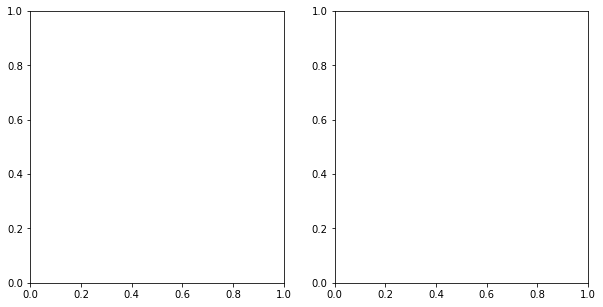

In [19]:
vars_to_plot = ['snow_depth', 'snow_CL_e3']

fig = plt.figure(figsize=(10,5))

axs = fig.subplots(1,2)

for counter, (var, ax, letter) in enumerate(zip(vars_to_plot, axs.reshape(-1), ascii_lowercase)):
    
    GR = False
    
    for angle, ls in zip([30,50,70], ['-', '--', ':']):
        
        legend_str = str(angle) + deg if angle else ""

        param_sensitivity(canonical,
                          var,
                          pretty_bounds,
                          ax=ax,
                          show=False,
                          angles=np.array([angle]),
                          ls=ls,
                          legend_str = legend_str,
                          GR=GR,
                          datapoints=10,
                          AMSR2=True)
    
    ax.annotate(text=f'({letter})', xy=(0.5,0.94), xycoords='axes fraction',
                fontsize='xx-large', ha='center', va='center')
    
    ax.set_ylabel('Brightness Temperature (K)', fontsize = 'x-large')


ax.legend(fontsize='large', loc='lower left')



# ax.set_ylim(-0.35,-0.12)

# plt.savefig('/home/robbie/Dropbox/nadir_radiometry/GR_two_panels.jpg',dpi=500,bbox_inches='tight')

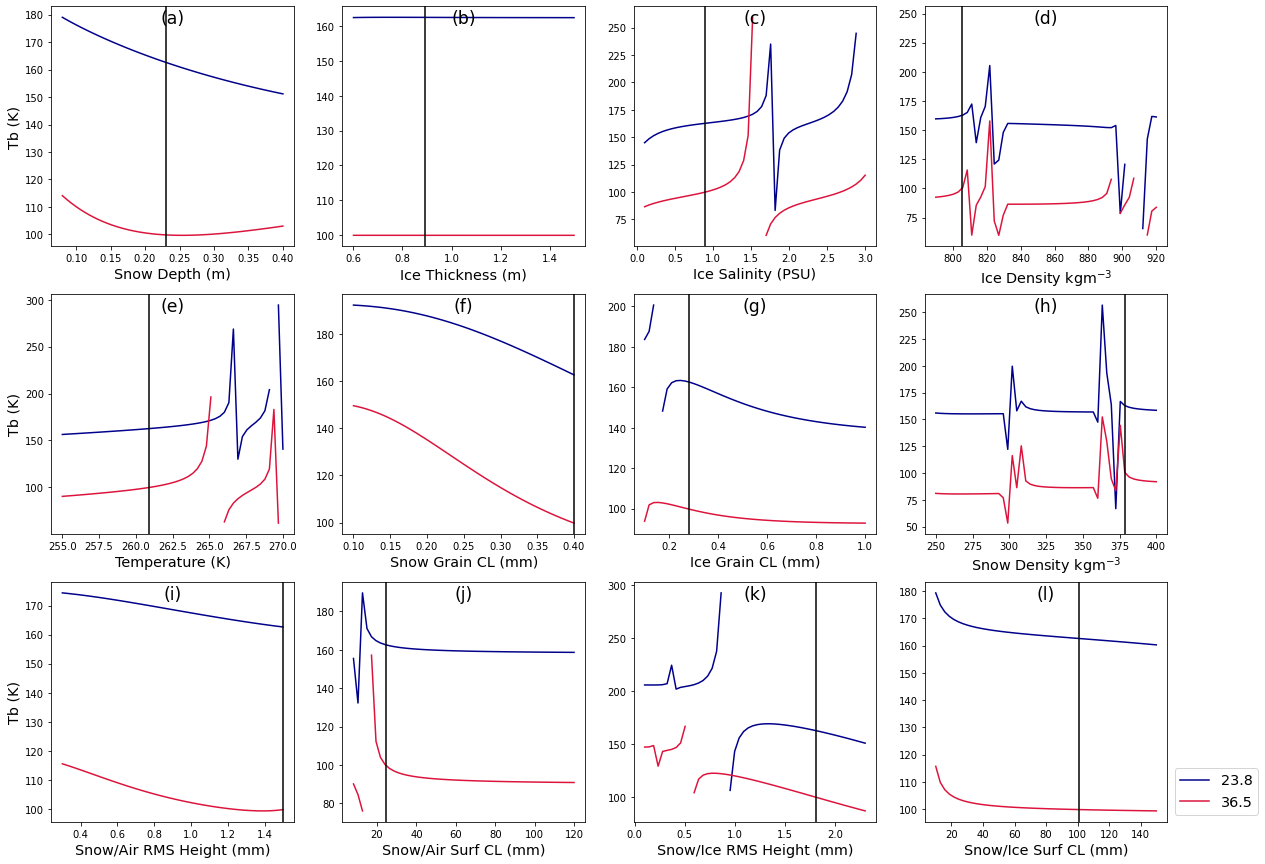

In [4]:
fig = plt.figure(figsize=(20,15))

axs = fig.subplots(3,4)

canonical.keys()

for counter, (var, ax, letter) in enumerate(zip(list(canonical.keys()), axs.reshape(-1), ascii_lowercase)):

    param_sensitivity(canonical, var, pretty_bounds, ax=ax, show=False)
    
    ax.axvline(x=canonical[var],color='k')
    
    ax.annotate(text=f'({letter})', xy=(0.5,0.95), xycoords='axes fraction',
                fontsize='xx-large', ha='center', va='center')
    
    if counter in [0,4,8]:
        ax.set_ylabel('Tb (K)', fontsize = 'x-large')
    else:
        ax.set_ylabel('')
    
h, l = ax.get_legend_handles_labels()

plt.legend(h, l,
           fontsize='x-large',
          loc='lower left',
          bbox_to_anchor=[1, 0]
          )


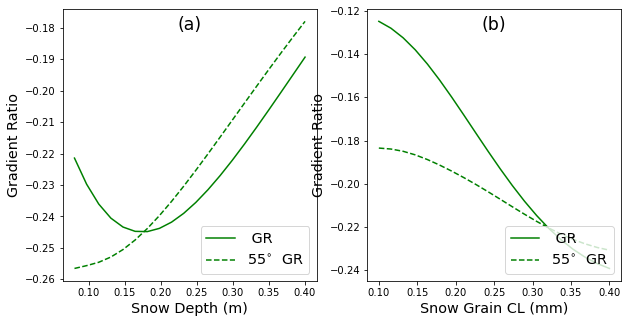

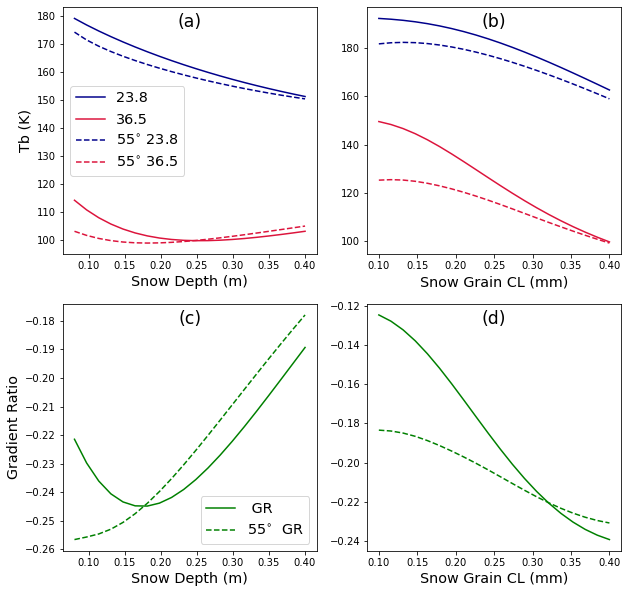

In [4]:
vars_to_plot = ['snow_depth', 'snow_CL_e3', 'snow_depth', 'snow_CL_e3']

fig = plt.figure(figsize=(10,10))

axs = fig.subplots(2,2)

for counter, (var, ax, letter) in enumerate(zip(vars_to_plot, axs.reshape(-1), ascii_lowercase)):
    
    GR = False if counter < 2 else True
    
    for angle, ls in zip([0,55], ['-', '--']):

        
        legend_str = str(angle) + deg if angle else ""
        
        param_sensitivity(canonical,
                          var,
                          pretty_bounds,
                          ax=ax,
                          show=False,
                          angles=np.array([angle]),
                          ls=ls,
                          legend_str = legend_str,
                          GR=GR,
                          datapoints=20)
    
#     ax.axvline(x=canonical[var],color='k')
    
    ax.annotate(text=f'({letter})', xy=(0.5,0.94), xycoords='axes fraction',
                fontsize='xx-large', ha='center', va='center')
    
    if counter == 0: 
        ax.set_ylabel('Tb (K)', fontsize = 'x-large')
        ax.legend(fontsize='x-large')
    elif counter == 2:
        ax.set_ylabel('Gradient Ratio', fontsize = 'x-large')
        ax.legend(fontsize='x-large', loc='lower right')



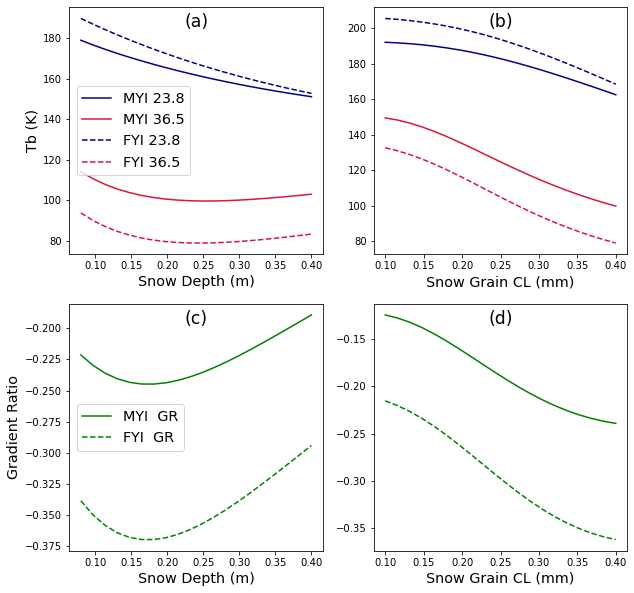

In [6]:
vars_to_plot = ['snow_depth', 'snow_CL_e3', 'snow_depth', 'snow_CL_e3']

fig = plt.figure(figsize=(10,10))

axs = fig.subplots(2,2)

for counter, (var, ax, letter) in enumerate(zip(vars_to_plot, axs.reshape(-1), ascii_lowercase)):
    
    GR = False if counter < 2 else True
    
    for ice_type, ls in zip(['multiyear','firstyear'], ['-', '--']):
        
        legend_str = 'MYI ' if ice_type == 'multiyear' else 'FYI '
        
        param_sensitivity(canonical,
                          var,
                          pretty_bounds,
                          ax=ax,
                          show=False,
                          ls=ls,
                          angles=np.array([0]),
                          legend_str=legend_str,
                          ice_type=ice_type,
                          GR=GR,
                          datapoints=20)
    
#     ax.axvline(x=canonical[var],color='k')
    
    ax.annotate(text=f'({letter})', xy=(0.5,0.94), xycoords='axes fraction',
                fontsize='xx-large', ha='center', va='center')
    
    if counter == 0: 
        ax.set_ylabel('Tb (K)', fontsize = 'x-large')
        ax.legend(fontsize='x-large')
    elif counter == 2:
        ax.set_ylabel('Gradient Ratio', fontsize = 'x-large')
        ax.legend(fontsize='x-large', loc='center left')

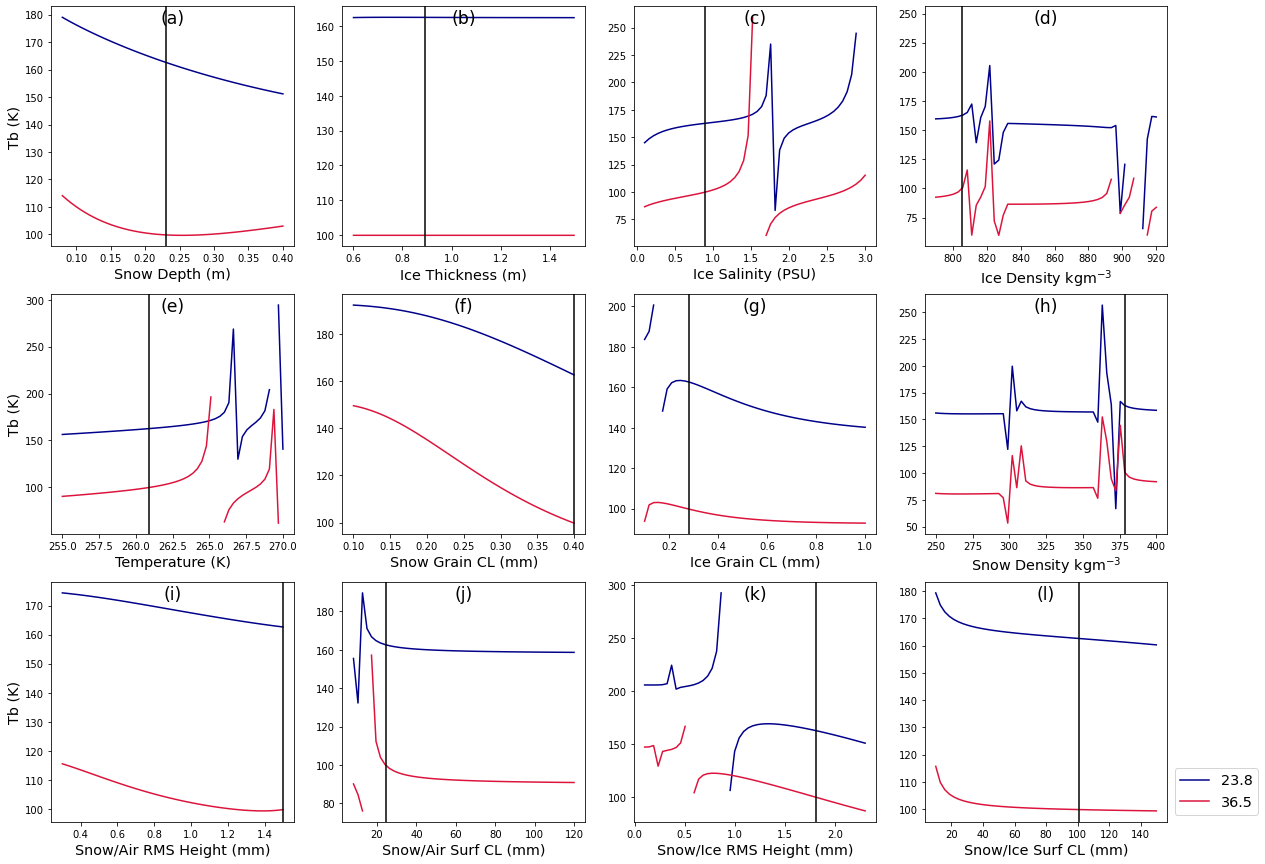

In [7]:
fig = plt.figure(figsize=(20,15))

axs = fig.subplots(3,4)

canonical.keys()

for counter, (var, ax, letter) in enumerate(zip(list(canonical.keys()), axs.reshape(-1), ascii_lowercase)):

    param_sensitivity(canonical, var, pretty_bounds, ax=ax, show=False)
    
    ax.axvline(x=canonical[var],color='k')
    
    ax.annotate(text=f'({letter})', xy=(0.5,0.95), xycoords='axes fraction',
                fontsize='xx-large', ha='center', va='center')
    
    if counter in [0,4,8]:
        ax.set_ylabel('Tb (K)', fontsize = 'x-large')
    else:
        ax.set_ylabel('')
    
h, l = ax.get_legend_handles_labels()

plt.legend(h, l,
           fontsize='x-large',
          loc='lower left',
          bbox_to_anchor=[1, 0]
          )

x low
circle high


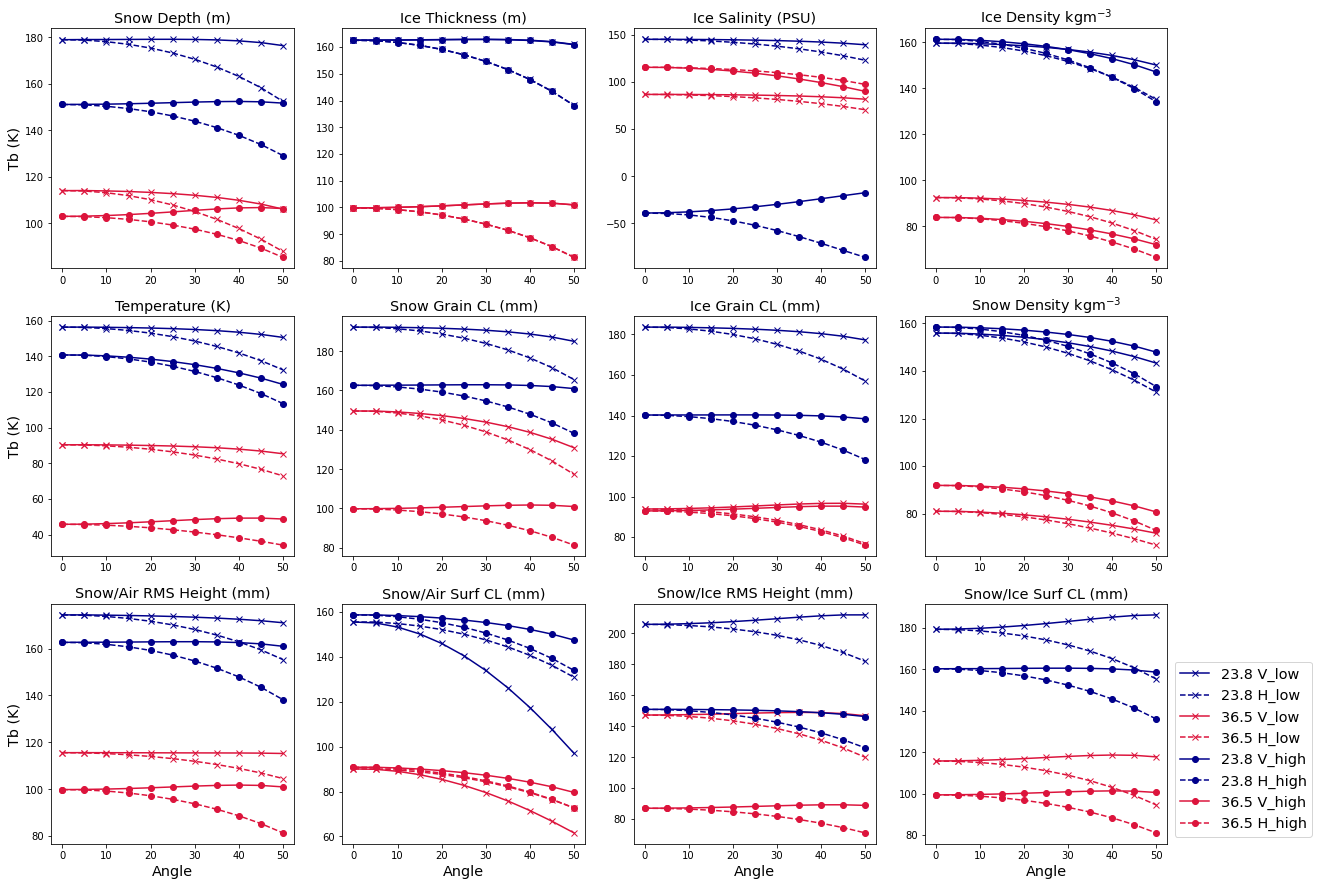

In [8]:
print('x low')
print('circle high')

fig = plt.figure(figsize=(20,15))

axs = fig.subplots(3,4)

canonical.keys()

for counter, (var, ax) in enumerate(zip(list(canonical.keys()), axs.reshape(-1))):

    angular_sensitivity(canonical, var, pretty_bounds, ax=ax, show=False)
    
    if counter in [0,4,8]:
        ax.set_ylabel('Tb (K)', fontsize = 'x-large')
    else:
        ax.set_ylabel('')
    
    ax.set_title(variable_titles[var], fontsize='x-large')
    
    if counter < 8:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Angle', fontsize = 'x-large')
        

#     fig.legend(custom_lines, legend_names)
    
h, l = ax.get_legend_handles_labels()

plt.legend(h, l,
           fontsize='x-large',
          loc='lower left',
          bbox_to_anchor=[1, 0]
          )

plt.show()

In [9]:
def nadir_sensitivity(canonical,
                variable,
                bounds,
                ax=0,
                show=True,
                penetration=False):
    trial_dict = canonical.copy()

    
    runs = {}
    
    for value, marker, description in zip([bounds[variable][0], bounds[variable][1]], ['x', 'o'], ['low', 'high']):
        
        trial_dict[variable] = value

        trial_params = [value for value in list(trial_dict.values())]

        run = run_sensitivity_from_params(trial_params)
        
        runs[description] = run
    
    return runs

x low
circle high


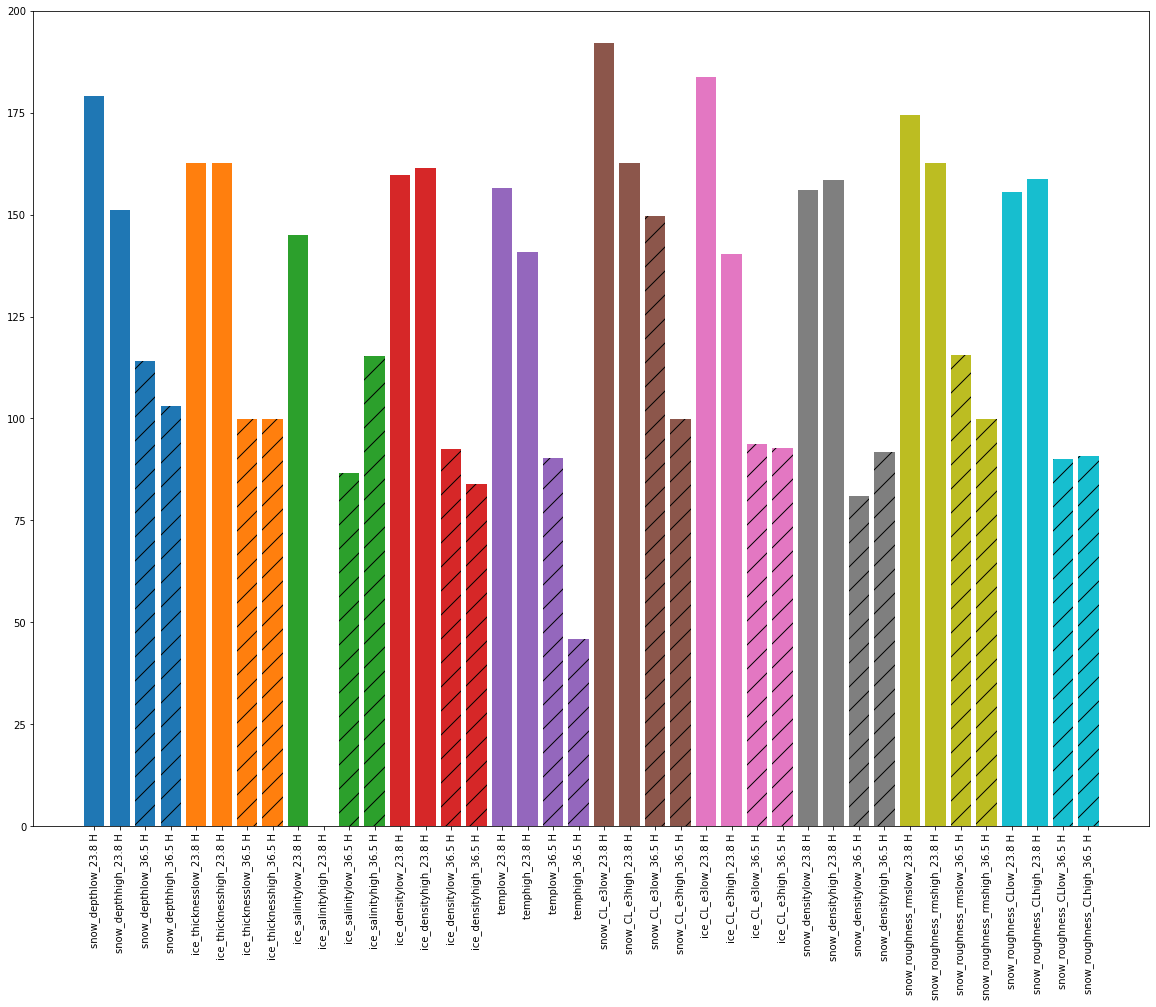

In [10]:
print('x low')
print('circle high')
prop_cycle = plt.rcParams['axes.prop_cycle']

fig = plt.figure(figsize=(20,15))

result = defaultdict(lambda: defaultdict(dict))

names = []
vals = []

for var in canonical.keys():

    runs = nadir_sensitivity(canonical, var, pretty_bounds, show=False)
    
    for ul_key in runs.keys():
    
        for key in runs[ul_key]:
            if 'H' in key:
                result[var][f'{ul_key}_{key}'] = runs[ul_key][key][0]
                
                
for var, color in zip(result.keys(), prop_cycle.by_key()['color']):
    
    for offset, hatch, frequency in zip([0,1], ['','/'], ['23.8','36.5']):
        
        var_names = [var + str(my_string) for my_string in list(result[var].keys())][offset::2]
        
        var_vals = list(result[var].values())[offset::2]
        
        plt.bar(var_names, var_vals, hatch=hatch, color=color)

plt.tick_params('x', rotation=90)    

plt.ylim(0, 200)

plt.show()